In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys

def get_dir_n_levels_up(path, n):
    # Go up n levels from the given path
    for _ in range(n):
        path = os.path.dirname(path)
    return path


proj_root = get_dir_n_levels_up(os.path.abspath("__file__"), 4)
sys.path.append(proj_root)


print(proj_root)

d:\Work\repos\RL\phd-rl-algos


In [3]:
import numpy as np
from rl_envs_forge.envs.network_graph.network_graph import NetworkGraph

from dqn.opinion_dynamics.utils.experiment import build_environment
from dqn.opinion_dynamics.experiments.algos import centrality_based_continuous_control

from dynamic_programming.opinion_dynamics.algos import compute_average_error, compute_final_average_error, generate_full_control_policy, generate_control_from_vector
from dynamic_programming.opinion_dynamics.algo_infinite_horizon import value_iteration, extract_policy, create_state_grid
from dynamic_programming.opinion_dynamics.common.viz import plot_opinions_over_time, visualize_policy_from_env, plot_action_heatmap, interpolate_opinion_trajectory


Ran for 27 steps: done=True, truncated=False


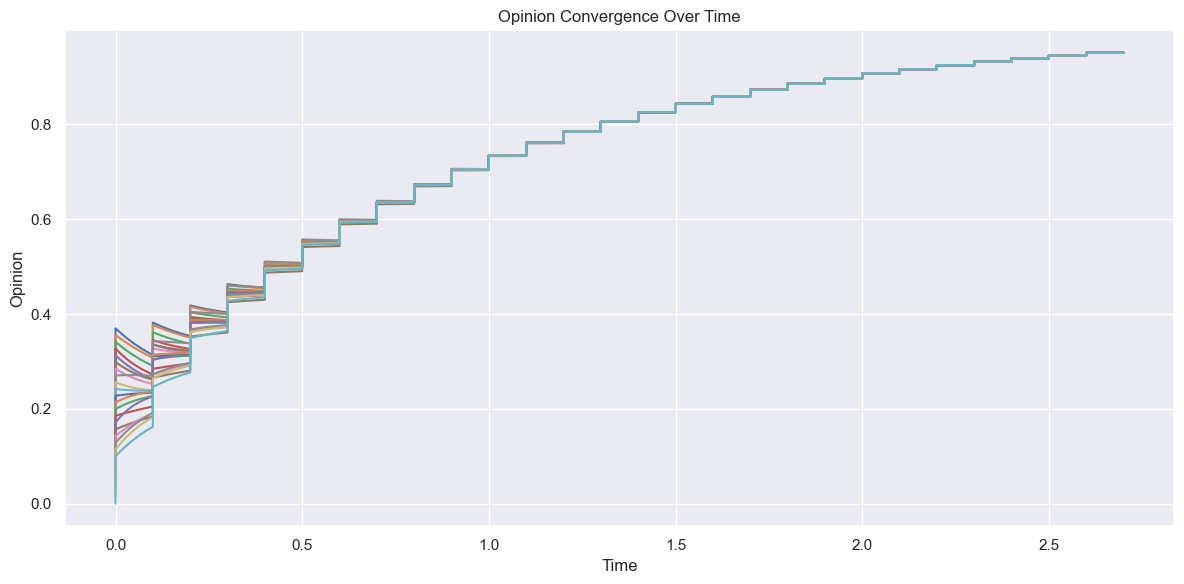

Total discounted reward: -7.9906


In [4]:
def run_policy(env, policy, nx, step_duration, max_steps=1000):
    """
    Run the simulation using a given policy with a maximum number of steps.

    Args:
        env: The environment with network properties.
        policy: The control policy to be used.
        nx: Number of grid points per dimension (used for mapping states to grid indices).
        step_duration: Duration of each policy application.
        tolerance: Tolerance for the mean opinion to stop the simulation.
        max_steps: Maximum number of steps to run.

    Returns:
        opinions_over_time: Array of opinions over the entire simulation.
        time_points: Corresponding time points for each opinion snapshot.
        rewards_over_time: Collected rewards at each step.
    """
    N = env.num_agents
    time_points = []
    rewards_over_time = []
    actions_over_time = []

    current_time = 0.0
    state, _ = env.reset()
    opinions_over_time = [state]
    grids = create_state_grid(N, nx)

    for step in range(max_steps):
        idx = tuple(np.abs(grids[i] - state[i]).argmin() for i in range(N))
        action = policy.get(idx, np.zeros(N))

        # print(action)
        next_state, reward, done, truncated, _ = env.step(action, env.tau)

        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        actions_over_time.append(action)
        time_points.append(current_time)
        # print(f"Step: {step}, Time: {current_time}, Reward: {reward}")

        current_time += step_duration
        state = next_state

        if done or truncated:
            break

    print(f"Ran for {step+1} steps: done={done}, truncated={truncated}")
    return (
        np.array(opinions_over_time),
        np.array(time_points),
        np.array(rewards_over_time),
        np.array(actions_over_time),
    )

env = build_environment()
num_steps = 50
nx = 2
available_budget = 2

# policy_broadcast = generate_full_control_policy(env, nx)
policy_uniform = np.full(env.num_agents, available_budget / env.num_agents)
policy_broadcast = generate_control_from_vector(env, nx, policy_uniform)

(opinions_over_time, time_points, rewards, actions) = run_policy(
    env, policy_broadcast, nx=nx, step_duration=env.tau, max_steps=num_steps
)

interpolated_opinions, interpolated_times = interpolate_opinion_trajectory(
    env, opinions_over_time, actions, n_substeps=10
)

# Plot
plot_opinions_over_time(interpolated_opinions, time_points=interpolated_times)

# sum(rewards)

gamma = 0.99

total_value = sum((gamma**i) * r for i, r in enumerate(rewards))
print(f"Total discounted reward: {total_value:.4f}")

In [5]:
# sum(rewards)

Centrality-based policy finished after 21 steps. Done=True, Truncated=False


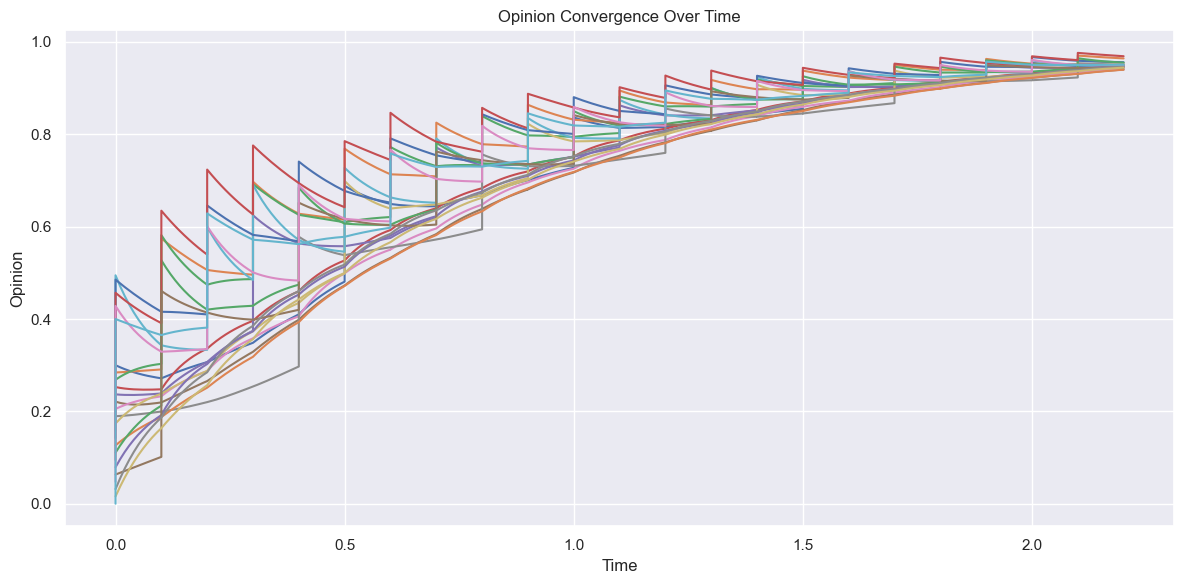

Total discounted reward: -6.6355


In [6]:


def run_centrality_policy(env, available_budget, step_duration, max_steps=1000):
    """
    Run the simulation using dynamic centrality-based continuous control.

    Args:
        env: The environment instance.
        available_budget (float): Total control budget per step.
        step_duration (float): Duration of each control application.
        max_steps (int): Maximum number of steps to run.

    Returns:
        opinions_over_time (np.ndarray): Array of opinions over time (steps+1, agents).
        time_points (np.ndarray): Array of time points.
        rewards_over_time (np.ndarray): Rewards collected at each step.
        actions_over_time (List[np.ndarray]): List of actions taken at each step.
    """
    time_points = []
    rewards_over_time = []
    actions_over_time = []
    current_time = 0.0

    state, _ = env.reset()
    opinions_over_time = [state.copy()]

    for step in range(max_steps):
        # Compute dynamic action based on centralities and current state
        action, controlled_nodes = centrality_based_continuous_control(env, available_budget)
        actions_over_time.append(action.copy())

        next_state, reward, done, truncated, _ = env.step(action, step_duration)

        opinions_over_time.append(next_state.copy())
        rewards_over_time.append(reward)
        time_points.append(current_time)

        current_time += step_duration
        state = next_state

        if done or truncated:
            print(f"Centrality-based policy finished after {step} steps. Done={done}, Truncated={truncated}")
            break

    return (
        np.array(opinions_over_time),
        np.array(time_points),
        np.array(rewards_over_time),
        actions_over_time,
    )



# --- Parameters ---
num_steps = 100
gamma = 0.99
available_budget = 2

# --- Build env ---
env = build_environment()

# --- Run policy ---
opinions_over_time, time_points, rewards, actions = run_centrality_policy(
    env,
    available_budget=available_budget,
    step_duration=env.tau,
    max_steps=num_steps
)

# --- Interpolate dynamics ---
interpolated_opinions, interpolated_times = interpolate_opinion_trajectory(
    env, opinions_over_time, actions, n_substeps=10
)

# --- Plot interpolated opinions ---
plot_opinions_over_time(interpolated_opinions, time_points=interpolated_times)

# --- Discounted reward ---
total_value = sum((gamma ** i) * r for i, r in enumerate(rewards))
print(f"Total discounted reward: {total_value:.4f}")

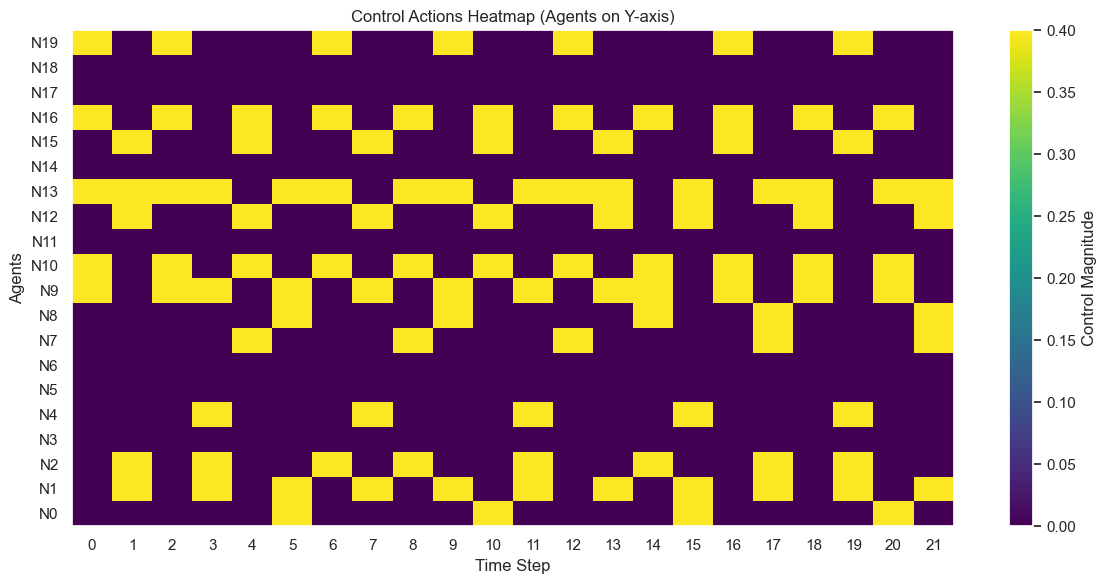

In [7]:
plot_action_heatmap(actions)

In [8]:
# Not feasable with lots of nodes

# env = build_environment()

# # Adjusted parameters
# step_duration = env.tau
# max_total_budget = 2
# action_levels = [0, 0.4]

# V = value_iteration(env, 
#                     action_levels=action_levels,
#                     nx=nx, 
#                     gamma=gamma,  
#                     step_duration=step_duration, 
#                     max_total_budget=max_total_budget)
# policy = extract_policy(
#     env, 
#     V, 
#     action_levels=action_levels, 
#     nx=nx, gamma=gamma, 
#     step_duration=step_duration, 
#     max_total_budget=max_total_budget
# )

In [9]:
# for node_index in range(env.num_agents):
#     visualize_policy_from_env(policy, env, nx=nx, node_index=node_index)

In [10]:
# env = build_environment()
# num_steps = 30

# opinions_over_time, time_points, rewards = run_policy(env, policy, nx=nx, step_duration=env.tau, max_steps=num_steps)
# plot_opinions_over_time(opinions_over_time)
# # sum(rewards)

# total_value = 0
# for i, r in enumerate(rewards):
#     total_value = total_value + (gamma**i) * r
    
# total_value

In [11]:
# env.opinions

In [12]:
# rewards

### DQN: 
Distributes budget beta_k (beta can be selected from discrete interval) across all nodes using W*
beta_k to be chosen constant

###  NAHS 
Distributes total budget B across M campaigns
At each campaign distributes the budget beta_k across all nodes using W_k
distribute the same beta_k as in the dqn experiment, and track